customer_id          0
age                  0
income               0
credit_score         0
loan_amount          0
interest_rate        0
loan_term            0
repayment_status     0
employment_status    0
region               0
dtype: int64

----------------------------------------
Logistic Regression
Cross-Validation ROC-AUC Scores: [0.61898486 0.59589587 0.63122627 0.62454735 0.61147627]
Mean ROC-AUC: 0.6164261221593199

Model Evaluation (CalibratedClassifierCV(estimator=LogisticRegression(C=100,
                                                    class_weight='balanced',
                                                    max_iter=1000, penalty='l1',
                                                    solver='liblinear'))):
Accuracy: 0.7215
Precision: 0.2092
Recall: 0.1689
F1 Score: 0.1869
ROC-AUC: 0.5255

----------------------------------------
Random Forest
Cross-Validation ROC-AUC Scores: [0.6384768  0.61869744 0.64868696 0.6422019  0.61943646]
Mean ROC-AUC: 0.6334999112917534

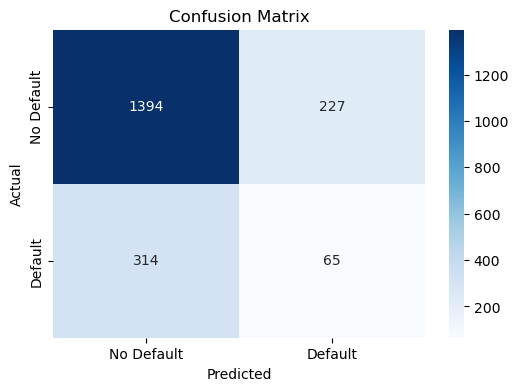

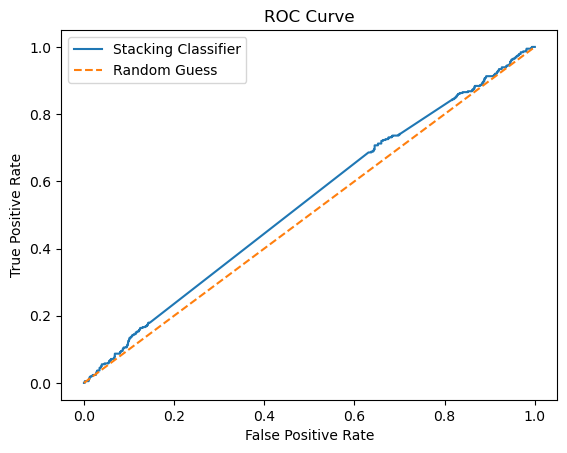

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from faker import Faker
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.feature_selection import RFE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek

# Initialize Faker and random seed for reproducibility
fake = Faker()
Faker.seed(42)
np.random.seed(42)

# Generate Synthetic Data using Faker
def generate_data(num_samples=10000):  # Increase the data size to 10,000
    data = []
    for _ in range(num_samples):
        customer_id = fake.uuid4()
        age = np.random.randint(18, 70)
        income = np.random.randint(25000, 150000)
        credit_score = np.random.randint(300, 850)
        loan_amount = np.random.randint(5000, 100000)
        interest_rate = np.random.uniform(3.0, 15.0)
        loan_term = np.random.choice([36, 60, 120])
        repayment_status = np.random.choice([0, 1], p=[0.8, 0.2])
        employment_status = np.random.choice(['Employed', 'Self-employed', 'Unemployed'], p=[0.6, 0.3, 0.1])
        region = np.random.choice(['Urban', 'Suburban', 'Rural'], p=[0.5, 0.3, 0.2])
        data.append([customer_id, age, income, credit_score, loan_amount, interest_rate, loan_term, repayment_status, employment_status, region])
    
    columns = ['customer_id', 'age', 'income', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term', 'repayment_status', 'employment_status', 'region']
    df = pd.DataFrame(data, columns=columns)
    return df

# Generate the synthetic dataset
df = generate_data(10000)

# Data Preprocessing
print(df.isnull().sum())

categorical_features = ['employment_status', 'region']
numerical_features = ['age', 'income', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term']

X = df.drop(columns=['customer_id', 'repayment_status'])
y = df['repayment_status']

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features),
                  ('cat', OneHotEncoder(), categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Combine SMOTE with Tomek Links for balanced resampling
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_res)
X_test_poly = poly.transform(X_test)

# Feature Selection with RFE
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', solver='liblinear')
rfe = RFE(log_reg, n_features_to_select=20)
X_train_rfe = rfe.fit_transform(X_train_poly, y_train_res)
X_test_rfe = rfe.transform(X_test_poly)

models = {
    'Logistic Regression': CalibratedClassifierCV(LogisticRegression(C=100, class_weight='balanced', max_iter=1000, penalty='l1', solver='liblinear')),
    'Random Forest': CalibratedClassifierCV(RandomForestClassifier(class_weight='balanced', max_features='log2', n_estimators=464)),
    'Gradient Boosting': CalibratedClassifierCV(GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=300))
}

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('Logistic Regression', models['Logistic Regression']),
                ('Random Forest', models['Random Forest']),
                ('Gradient Boosting', models['Gradient Boosting'])],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', solver='liblinear'))

# Model Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print(f"\nModel Evaluation ({model}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    return accuracy, precision, recall, f1, roc_auc

# Stratified K-Folds Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model with cross-validation and final evaluation
for model_name, model in models.items():
    print(f"\n{'-'*40}\n{model_name}")
    scores = cross_val_score(model, X_train_rfe, y_train_res, cv=kf, scoring='roc_auc')
    print(f'Cross-Validation ROC-AUC Scores: {scores}')
    print(f'Mean ROC-AUC: {np.mean(scores)}')
    evaluate_model(model, X_train_rfe, X_test_rfe, y_train_res, y_test)

print(f"\n{'-'*40}\nStacking Classifier")
evaluate_model(stacking_clf, X_train_rfe, X_test_rfe, y_train_res, y_test)

# Visualizing Results
y_pred = stacking_clf.predict(X_test_rfe)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, stacking_clf.predict_proba(X_test_rfe)[:, 1])
plt.plot(fpr, tpr, label='Stacking Classifier')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()